In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, LSTM, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import os
from os.path import join
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import gc
import time
import json
import multiprocessing
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental_run_functions_eagerly(True)

In [1]:
!nvidia-smi

Thu May 14 07:54:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!wget https://big.galqiwi.ru/toshare/dataset.json

--2020-05-09 01:11:55--  https://big.galqiwi.ru/toshare/dataset.json
Resolving big.galqiwi.ru (big.galqiwi.ru)... 185.5.248.186
Connecting to big.galqiwi.ru (big.galqiwi.ru)|185.5.248.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152073197 (145M) [application/json]
Saving to: ‘dataset.json’

dataset.json        100%[===================>] 145.03M  7.42MB/s    in 24s     

2020-05-09 01:12:20 (6.07 MB/s) - ‘dataset.json’ saved [152073197/152073197]



In [ ]:
with open('dataset.json', 'r') as file:
  dataset = json.load(file)
dataset = [_ for _ in dataset if _ != None and _ != {}]
gc.collect()

In [0]:
test_dataset = dataset[-10000:]
dataset = dataset[:-10000]
print(len(dataset), len(test_dataset))

642257 10000


In [0]:
input_dim = 96 * 128
latent_dim = 500
hldim = 4000

inp = Input((96, 128))
x = tf.keras.layers.Flatten()(inp)
x = Dense((hldim), 'relu')(x)
x = Dense(latent_dim * 2)(x)
encoder_model = Model(inp, x)

inp = Input(latent_dim)
x = Dense((hldim), 'relu')(inp)
x = Dense(96 * 128, 'sigmoid')(x)
x = Reshape((96, 128))(x)
decoder_model = Model(inp, x)

opt = tf.keras.optimizers.Adam()

In [0]:
def set_measure(frame, data_compressed):
  for key in data_compressed:
    for press in data_compressed[key]:
      for _ in range(press[0], press[1]):
        frame[_][int(key)] = 1

In [0]:
raw_test = np.zeros((10000, 96, 128))
for _ in range(len(test_dataset)):
  set_measure(raw_test[_], test_dataset[_])

In [0]:
@tf.function
def train_on_batch(batch):
    with tf.GradientTape() as tape:
        tv = decoder_model.trainable_variables + encoder_model.trainable_variables
        tape.watch(tv)
        pred = encoder_model(batch)
        mid = pred[:,:latent_dim]
        logsigm = pred[:,latent_dim:]
        eps = tf.random.normal(shape=mid.shape)
        pred_mid = eps * tf.exp((logsigm - 1) * .5) + mid
        pred = decoder_model(pred_mid)
        L0 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(batch, pred)) * 100
        L1 = tf.keras.backend.mean((tf.exp(logsigm) - 1. - logsigm) * 1.0 + tf.square(mid)) * 0.75
        L = L0 + L1
    grad = tape.gradient(L, tv)
    opt.apply_gradients(zip(grad, tv))
    return (L, L0, L1)

@tf.function
def test_model():
  v = encoder_model(raw_test)[:,:latent_dim]
  out = decoder_model(v)
  return tf.reduce_mean(tf.keras.losses.binary_crossentropy(raw_test, out))

def train_on_compress_batch(batch):
  data = np.zeros((len(batch), 96, 128))
  for _ in range(len(batch)):
    set_measure(data[_], batch[_])
  out =  train_on_batch(data)
  data = None
  gc.collect()
  return out

In [0]:
filling = np.mean(raw_test)

In [0]:
def show_plots(trimmer = 0):
  tags = sorted(losses_tests.keys())
  legend_ = []
  for _ in tags:
    plt.plot('x', 'y', data={'x': losses_tests[_]['x'][trimmer:], 'y': losses_tests[_]['y1'][trimmer:] / filling})
    legend_.append(_)
    plt.plot('x', 'y', data={'x': losses_tests[_]['x'][trimmer:], 'y': losses_tests[_]['y2'][trimmer:] / filling})
    legend_.append(_ + '_v')
  plt.yscale('log')
  plt.legend(legend_)
  clear_output(True)
  plt.show()

In [0]:
losses_tests = {}

In [0]:
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.0)

In [0]:
def save_loss():
  global losses_tests
  with open('gdrive/My Drive/midi-vae-500/loss', 'w') as file:
    keyname = list(losses_tests.keys())[0]
    x = losses_tests[keyname]['x']
    y = [float(_) for _ in losses_tests[keyname]['y']]
    y1 = [float(_) for _ in losses_tests[keyname]['y1']]
    y2 = [float(_) for _ in losses_tests[keyname]['y2']]
    file.write(json.dumps([x, y, y1, y2]))

In [0]:
with open('gdrive/My Drive/midi-vae-500/loss', 'r') as file:
  _ = json.loads(file.read())
  key_name = 'test_fixed_batches_{0}_{1}'.format(2 ** 13, 6000000)
  losses_tests[key_name] = {}
  losses_tests[key_name]['x'] = _[0]
  losses_tests[key_name]['y'] = _[1]
  losses_tests[key_name]['y1'] = _[2]
  losses_tests[key_name]['y2'] = _[3]
  #print(key_name[1])

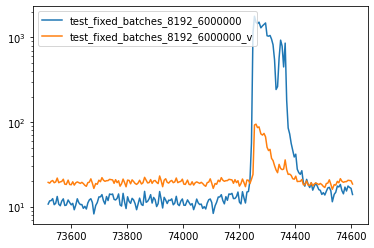

In [0]:
show_plots(-200)

In [0]:
max_time = sorted([int(_.split('_')[-1][:-3]) for _ in os.listdir('gdrive/My Drive/midi-vae-500') if _[-3:] == '.h5' and _[0] == 'e'])[-1]
encoder_model = load_model(f'gdrive/My Drive/midi-vae-500/encoder_4000-500_{max_time}.h5')
decoder_model = load_model(f'gdrive/My Drive/midi-vae-500/decoder_4000-500_{max_time}.h5')

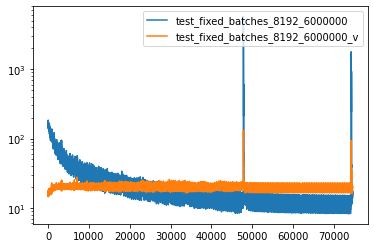

KeyboardInterrupt: ignored

In [0]:
def test_fixed_batches(batch_size = 1024, max_time = 6000000):
  global losses_tests
  name = 'test_fixed_batches_{0}_{1}'.format(batch_size, max_time)
  #out = {'x': [], 'y': [], 'y1': [], 'y2': []}
  #begin = time.time()
  out = losses_tests[name]
  begin = time.time() - out['x'][-1]
  batches = dataset[:len(dataset) // batch_size * batch_size]
  batches = [[batches[__ + _ * batch_size] for __ in range(batch_size)] for _ in range(len(batches) // batch_size)]
  batch_id = np.random.randint(0, len(batches))
  # return 0
  while True:
    L = train_on_compress_batch(batches[batch_id])
    batch_id = (batch_id + 1) % len(batches)
    current_time = time.time() - begin
    if batch_id % 30 == 0:
     decoder_model.save('gdrive/My Drive/midi-vae-500/decoder_4000-500_{}.h5'.format(int(current_time)))
     encoder_model.save('gdrive/My Drive/midi-vae-500/encoder_4000-500_{}.h5'.format(int(current_time)))
     save_loss()
    if current_time > max_time:
      break
    else:
      out['x'].append(current_time)
      out['y'].append(L[0].numpy())
      out['y1'].append(L[1].numpy())
      out['y2'].append(L[2].numpy())
      losses_tests[name] = out
      show_plots()

test_fixed_batches(2 ** 13)
#test_unfixed_batches(2 ** 10)
#test_fixed_batches(2 ** 11)
#test_unfixed_batches(2 ** 11)
#test_fixed_batches(2 ** 12)
#test_unfixed_batches(2 ** 12)
#test_fixed_batches(2 ** 13)
#test_unfixed_batches(2 ** 13)

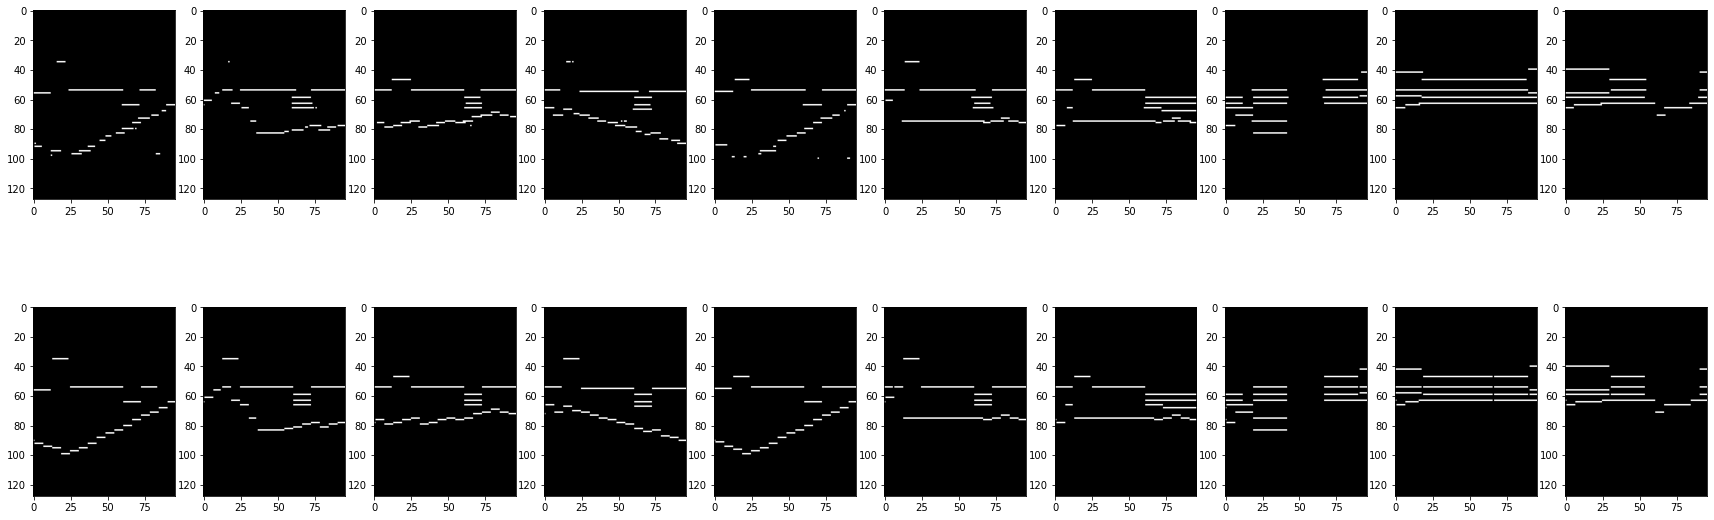

In [0]:
def autoencode(x):
  return decoder_model(encoder_model(x)[:,:latent_dim]).numpy()

plt.figure(figsize=(30, 10))

SHIFT = 600
for _ in range(10):
  plt.subplot(2, 10, 1 + _)
  plt.imshow(autoencode(raw_test[SHIFT + _].reshape((-1, 96, 128)))[0].T > 0.5, cmap='gray')
  plt.subplot(2, 10, 11 + _)
  plt.imshow(raw_test[SHIFT + _].T, cmap='gray')

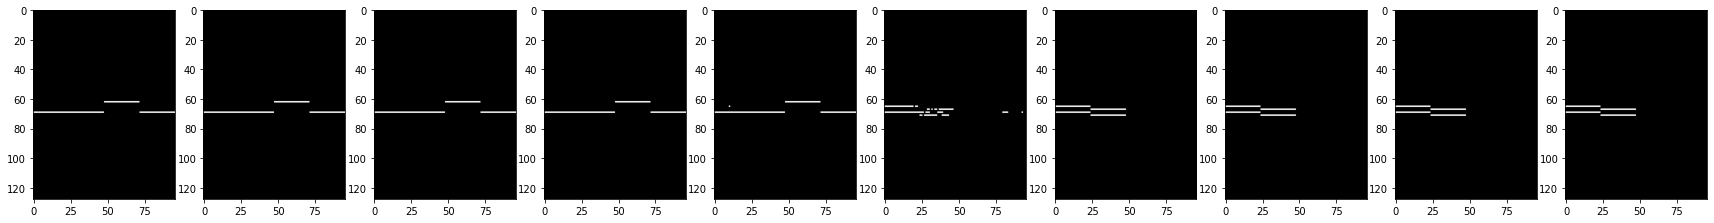

In [0]:
plt.figure(figsize=(30, 5))
TEST_ID_0 = 45
TEST_ID_1 = 44
v_0 = encoder_model(raw_test[TEST_ID_0].reshape(-1, 96, 128)).numpy().reshape(-1)[:latent_dim]
v_1 = encoder_model(raw_test[TEST_ID_1].reshape(-1, 96, 128)).numpy().reshape(-1)[:latent_dim]

out_melody = []
for _ in range(10):
  v = (v_0 * _ + v_1 * (9 - _)) / 9.
  img = decoder_model(v.reshape(1, -1)).numpy().reshape(96, 128)
  out_melody.append(img > 0.5)
  plt.subplot(1, 10, 1 + _)
  plt.imshow(img.T > 0.5, cmap='gray')
out_melody = np.array(out_melody)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
v_space = encoder_model(raw_test).numpy()[:,:latent_dim]

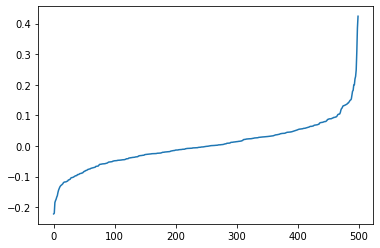

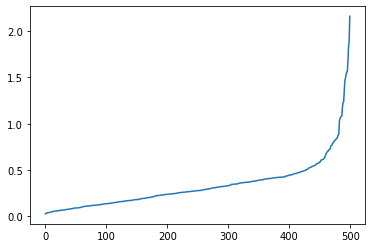

In [0]:
plt.plot(sorted(list(np.mean(v_space, axis=0))))
plt.show()
plt.plot(sorted(list(np.mean((v_space - mean_value_encoder_final) * (v_space - mean_value_encoder_final), axis=0))))
plt.show()

In [0]:
decoder_model = load_model('gdrive/My Drive/midi-vae-500/decoder_4000-500_73845.h5')
encoder_model = load_model('gdrive/My Drive/midi-vae-500/encoder_4000-500_73845.h5')

In [0]:
!mv gdrive/My\ Drive/midi-vae-500/decoder_4000-500_73845.h5 gdrive/My\ Drive/midi-vae-4-lstm
!mv gdrive/My\ Drive/midi-vae-500/encoder_4000-500_73845.h5 gdrive/My\ Drive/midi-vae-4-lstm

In [0]:
mean_value_encoder_final = np.mean(v_space, axis=0)
sigmas_value_encoder_final = np.sqrt(np.mean((v_space - mean_value_encoder_final) * (v_space - mean_value_encoder_final), axis=0))

In [0]:
np.save('gdrive/My Drive/midi-vae-500/mean_value_encoder_final', mean_value_encoder_final)
np.save('gdrive/My Drive/midi-vae-500/sigmas_value_encoder_final', sigmas_value_encoder_final)

In [0]:
print(mean_value_encoder_final.shape, sigmas_value_encoder_final.shape)

(500,) (500,)


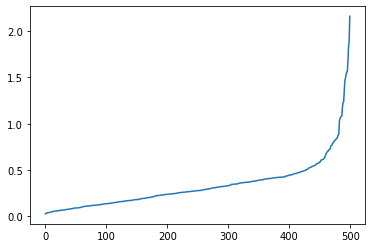

In [0]:
plt.plot(sorted(sigmas_value_encoder_final))

In [0]:
#!mkdir -p gdrive/My\ Drive/vae-models
#print(losses_tests[list(losses_tests.keys())[0]]['x'][-1])
#decoder_model.save('gdrive/My Drive/vae-models/decoder_32k_2000-200.h5')
#encoder_model.save('gdrive/My Drive/vae-models/encoder_32k_2000-200.h5')

In [0]:
!pip install pypianoroll
import pypianoroll as ppr

In [0]:
ppr.Multitrack(tempo=80, tracks=[ppr.Track(pianoroll=out_melody.reshape(-1, 128) * 100)]).write('/content/gdrive/My Drive/midi-final-res/{0}.mid'.format('test'))